In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xtrack as xt
import xcoll as xc
import xpart as xp
import xobjects as xo

In [3]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
env = line.env
#crab cavities: acfcah.61738 and acfcah.61739
crab1 = xt.CrabCavity(crab_voltage=1e6, frequency = line['actcse.31632'].frequency, lag=0)
crab2 = xt.CrabCavity(crab_voltage=1e6, frequency = line['actcse.31632'].frequency, lag=0)
env.elements['acfcah.61738'] = crab1
env.elements['acfcah.61739'] = crab2
tt = line.get_table()

In [5]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tt = line.get_table()
    tw = line.twiss()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [6]:
num_particles = 1000
num_turns = 3000
plane = 'H'
amplitude_adt = 0.07
nemitt_x = 2e-6
nemitt_y = 2e-6

In [7]:
remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tidp = install_tidp(line, block_mvt=29e-3)
tcsm = install_tcsm(line)

Slicing line:   0%|          | 0/32250 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/32250 [00:00<?, ?it/s]

In [8]:
adt = xc.BlowUp.install(line, name=f'adt_{plane}_blowup', at_s=line.get_s_position('adkcv.32171'), plane=plane, stop_at_turn=num_turns,
                        amplitude=amplitude_adt, use_individual_kicks=False, start_at_turn=500)

In [9]:
tw = line.twiss()
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)

In [10]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.2333663781336932m.
... distance to target bunch length: -2.2228e-01
... distance to target bunch length: 4.5424e-03
... distance to target bunch length: 4.3382e-03
... distance to target bunch length: -6.6565e-03
... distance to target bunch length: 2.0203e-03
... distance to target bunch length: -5.7185e-04
... distance to target bunch length: 1.0779e-04
... distance to target bunch length: 4.7891e-06
... distance to target bunch length: -2.0504e-09
... distance to target bunch length: 9.6490e-08
--> Bunch length: 0.22399999794961264
--> Emittance: 0.34350824485557363


In [11]:
adt.calibrate_by_emittance(nemitt=nemitt_x, twiss=tw)

In [12]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.scattering.enable()
adt.activate()
line.track(part, num_turns=num_turns, time=True, with_progress=1)
adt.deactivate()
line.scattering.disable()
print(f"Done tracking in {line.time_last_track:.1f}s.")

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/3000 [00:00<?, ?it/s]

Done tracking in 320.4s.


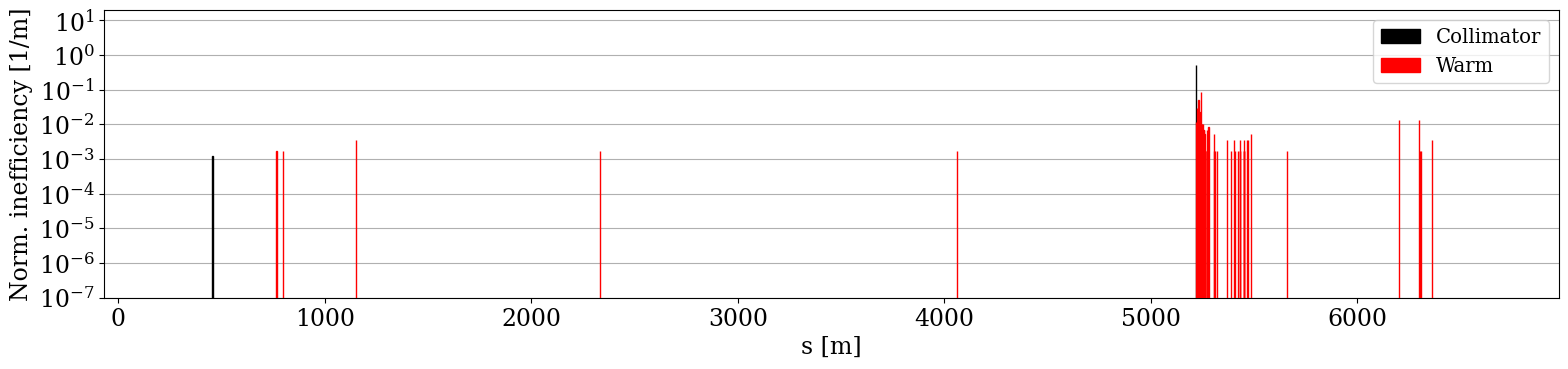

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='s [m]', ylabel='Norm. inefficiency [1/m]'>)

In [13]:
ThisLM = xc.LossMap(line = line, line_is_reversed=False, part=part, interpolation=False)
ThisLM.plot()

In [14]:
np.unique(part.at_turn, return_counts=True)

(array([   0,    1,    2,    3,    9,   10,   11,   16,   17,   18,   19,
          25,   26,   27,   45,   55,   57,   60,   63,   83,  102,  110,
         143,  147,  188,  505,  506,  510,  512,  514,  518,  526,  527,
         530,  531,  532,  535,  536,  545,  546,  555,  560,  561,  564,
         572,  581,  583,  586,  589,  590,  594,  597,  602,  603,  605,
         606,  611,  612,  615,  617,  624,  655,  659,  663,  664,  665,
         666,  667,  672,  674,  676,  680,  689,  737,  804,  813,  814,
         815,  820,  822,  825,  830,  831,  839,  843,  846,  847,  852,
         853,  854,  856,  857,  860,  861,  864,  865,  868,  869,  871,
         872,  873,  874,  875,  876,  877,  878,  879,  881,  882,  883,
         885,  886,  887,  889,  890,  893,  894,  898,  913,  914,  918,
         919,  922,  923,  931,  934,  935,  947,  951,  955,  959,  960,
         963,  964,  967,  968,  972,  973, 1092, 1096, 1100, 1104, 1117,
        1146, 1152, 1160, 1214, 1218, 

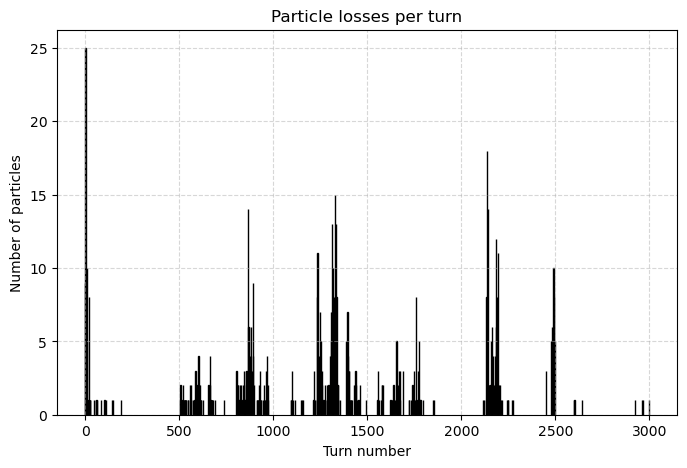

In [ ]:
mask = part.state > 0
unique_turns, counts = np.unique(part.at_turn[~mask], return_counts=True)

# Plot histogram-like bar chart
plt.figure(figsize=(8, 5))
plt.bar(unique_turns, counts, width=1.0, edgecolor='black')
plt.xlabel("Turn number")
plt.ylabel("Number of particles")
plt.title("Particle losses per turn")
plt.grid(True, linestyle='--', alpha=0.5)
# plt.savefig('../20251031/blowup_after_500_turns.png', dpi=300)
plt.show()

In [ ]:
np.unique(part.state, return_counts=True)

(array([-331,    0,    1]), array([536, 249, 215]))

In [ ]:
part.at_turn

array([3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 30

In [ ]:
mask = part.at_turn < 5

In [ ]:
line.element_names[24326]

'vcal.51939.b_aper'

In [ ]:
np.unique(part.at_element[mask], return_counts=True)

(array([24309, 24314, 24326, 24342, 24391]), array([26,  1,  3,  1,  2]))